In [1]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

from backflip import *
from local_augmentations import *

# Inpaint with Lama

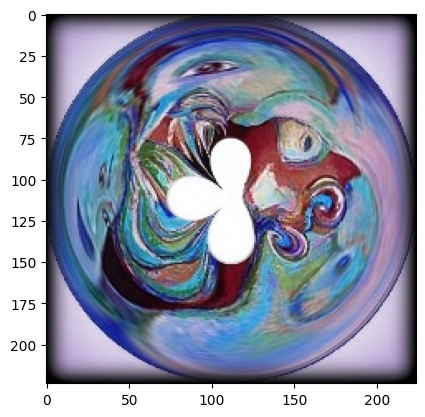

In [51]:
def lama_inpaint(img: np.ndarray, img_name: str, mask_name: str, inpainted_dir: str,
                 dilated_mask_dir: str = 'dilated_masks', inpainted_imgs_dir: str = 'inpainted_imgs') -> np.ndarray:
    """
    Inpaints the given image using the corresponding inpainted and dilated mask images.

    Args:
        img (np.ndarray): The original image to be inpainted.
        img_name (str): The name of the original image file.
        mask_name (str): The name of the mask file.
        inpainted_dir (str): The directory where the inpainted images are stored.
        dilated_mask_dir (str, optional): The directory where the dilated mask images are stored. Defaults to 'dilated_masks'.
        inpainted_imgs_dir (str, optional): The directory where the inpainted images are stored. Defaults to 'inpainted_imgs'.

    Returns:
        np.ndarray: The inpainted image.
    """
    img_name_no_ext = img_name[:img_name.find('.')]
    dilated_mask_file = f'{img_name_no_ext}_mask00{int(mask_name[:mask_name.find('.')]) + 1}.png'

    dilated_mask = cv2.imread(os.path.join(inpainted_dir, dilated_mask_dir, dilated_mask_file))
    inpainted = cv2.imread(os.path.join(inpainted_dir, inpainted_imgs_dir, dilated_mask_file))
    
    boolMask = np.all(dilated_mask == 255, axis=-1)
    img[boolMask] = inpainted[boolMask]

    return img

image_name = '_kimmg_2831596875.jpg'
mask_name = '1.png'
img = cv2.imread('inpainted_tad66k/dilated_masks/_kimmg_2831596875.png')

inpainted = lama_inpaint(img, image_name, mask_name, 'inpainted_tad66k')
plt.imshow(img)
plt.show()

# Backflip main function

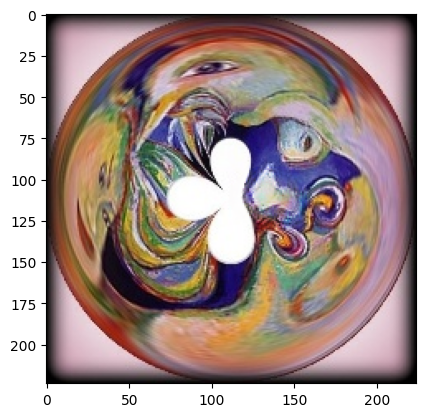

In [112]:
def backflip(img: np.ndarray, img_name: str, possible_aug: list, aug_prob: list, num_of_segments: int, segment_dir: str = 'segments',
             inpaint_method: str = 'telea', lama_inpainted_dir: str = None) -> np.ndarray:
    """
    Apply backflip augmentation to an image.

    Args:
        img (np.ndarray): The input image.
        img_name (str): The name of the image.
        possible_aug (list): List of possible augmentation functions.
        aug_prob (list): List of probabilities for each augmentation function.
        num_of_segments (int): Number of segments to select for augmentation.
        segment_dir (str, optional): Directory where the segments are stored. Defaults to 'segments'.
        inpaint_method (str, optional): Inpainting method to fill the background. Defaults to 'telea'.

    Returns:
        np.ndarray: The augmented image.
    """
    
    # Check inpaint method
    if inpaint_method not in ['telea', 'ns', 'mean', 'median', 'lama']:
        raise ValueError('Inpaint method not recognized.')

    # Get the segment names
    folder_name = img_name[:img_name.rfind('.')]
    segment_names = [f for f in os.listdir(os.path.join(segment_dir, folder_name)) if os.path.isfile(os.path.join(segment_dir, folder_name, f))]

    # Selected segments
    if num_of_segments > len(segment_names):
        selected_segments = segment_names
    else:
        selected_segments = np.random.choice(segment_names, num_of_segments, replace=False)

    unchanged_img = img.copy()

    # Augmentation loop
    for segment in selected_segments:
        # Opening mask
        mask = cv2.imread(os.path.join(segment_dir, folder_name, segment))
        mask_bool = mask.any(axis=2).astype(bool)

        # Filling background
        if inpaint_method == 'telea':
            mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            inpaint = cv2.inpaint(img, mask_gray, 3, cv2.INPAINT_TELEA)
            img[mask_bool] = inpaint[mask_bool]
        elif inpaint_method == 'ns':
            mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            inpaint = cv2.inpaint(img, mask_gray, 3, cv2.INPAINT_NS)
            img[mask_bool] = inpaint[mask_bool]
        elif inpaint_method == 'mean':   
            edges = cv2.subtract(cv2.dilate(mask, np.ones((6, 6), np.uint8), iterations=2), mask)
            edges = cv2.bitwise_and(img, edges)
            median_color = np.mean(edges[edges.sum(axis=2) > 0], axis=0)
            img[mask_bool] = median_color
        elif inpaint_method == 'median':
            mask_bool = mask.any(axis=2).astype(bool)
            edges = cv2.subtract(cv2.dilate(mask, np.ones((6, 6), np.uint8), iterations=2), mask)
            edges = cv2.bitwise_and(img, edges)
            median_color = np.median(edges[edges.sum(axis=2) > 0], axis=0)
            img[mask_bool] = median_color
        elif inpaint_method == 'lama':
            if lama_inpainted_dir is None:
                raise ValueError('Lama inpainted directory not provided.')
            img = lama_inpaint(img, img_name, segment, lama_inpainted_dir)

        # # Augmenting the segment
        bbox = get_segment_bounding_box(mask)
        cut_img = unchanged_img[bbox['min_y']:bbox['max_y'], bbox['min_x']:bbox['max_x']]
        cut_mask = mask[bbox['min_y']:bbox['max_y'], bbox['min_x']:bbox['max_x']]

        selected_augmentation = np.random.choice(possible_aug, p=aug_prob)
        augmented_segment = selected_augmentation(cut_img, cut_mask)

        # Inserting the augmented segment
        img = insert_element(img, augmented_segment['img'], augmented_segment['mask'], (bbox['center_y'], bbox['center_x']))

        return img

image_name = '_kimmg_2831596875.png'
img = cv2.imread(os.path.join('inpainted_tad66k','dilated_masks', image_name))

h = backflip(img, image_name, [removal], [1.0], 1, inpaint_method='lama', lama_inpainted_dir='inpainted_tad66k')
h = cv2.cvtColor(h, cv2.COLOR_BGR2RGB)

plt.imshow(h)
plt.show()